---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [ ]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# df.printSchema() # comment this line when rendering the submission
# df.show(5)

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [30]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop rows with missing values in key columns
df = df.dropna(subset=[
    "SALARY", 
    "DURATION", 
    "MIN_YEARS_EXPERIENCE", 
    "EMPLOYMENT_TYPE_NAME"
])

categorical_cols = [
    "EMPLOYMENT_TYPE_NAME"
]

# Create pipeline stages for categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') 
            for col in categorical_cols]

# Set dropLast=True to avoid perfect multicollinearity
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec", dropLast=True) 
            for col in categorical_cols]

# Assemble all features
assembler = VectorAssembler(
    inputCols=["DURATION", "MIN_YEARS_EXPERIENCE"] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features",
    handleInvalid="skip"
)

# Create and run pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df)

# Show the transformed data with features
data.select("SALARY", "DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME", "features").show(5, truncate=False)

+------+--------+--------------------+----------------------+-------------------+
|SALARY|DURATION|MIN_YEARS_EXPERIENCE|EMPLOYMENT_TYPE_NAME  |features           |
+------+--------+--------------------+----------------------+-------------------+
|192800|55      |6                   |Full-time (> 32 hours)|[55.0,6.0,1.0,0.0] |
|125900|18      |12                  |Full-time (> 32 hours)|[18.0,12.0,1.0,0.0]|
|118560|20      |5                   |Full-time (> 32 hours)|[20.0,5.0,1.0,0.0] |
|192800|55      |6                   |Full-time (> 32 hours)|[55.0,6.0,1.0,0.0] |
|116500|16      |12                  |Full-time (> 32 hours)|[16.0,12.0,1.0,0.0]|
+------+--------+--------------------+----------------------+-------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [32]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(11604, 134)


(2812, 134)


My justification for 80/20 Split is to have a larger training set (80%) which is better for model learning and sufficient testing set (20%) for reliable evaluation of generalization performance.

# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [41]:
from pyspark.ml.regression import LinearRegression
import pandas as pd

# Initialize OLS model (no regularization)
lr_ols = LinearRegression(featuresCol="features", 
                        labelCol="SALARY",
                        solver="normal")  # Critical for getting statistics

# Fit model
lr_model = lr_ols.fit(train_data)
summary = lr_model.summary

# Get feature names (same as before)
feature_names = []
continuous_features = ["DURATION", "MIN_YEARS_EXPERIENCE"]
feature_names.extend(continuous_features)

categorical_col = "EMPLOYMENT_TYPE_NAME"
categories = train_data.select(categorical_col).distinct().rdd.flatMap(lambda x: x).collect()
categories = categories[:-1]  # Remove reference category
feature_names.extend([f"{categorical_col}_{cat}" for cat in categories])

# Create results DataFrame
results = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': [lr_model.intercept] + list(lr_model.coefficients),
    'Std Error': summary.coefficientStandardErrors,
    't-value': summary.tValues,
    'p-value': summary.pValues
})

# Add confidence intervals
results['CI Lower'] = results['Coefficient'] - 1.96*results['Std Error']
results['CI Upper'] = results['Coefficient'] + 1.96*results['Std Error']

# Display results
print("Significant Coefficients (p < 0.05):")
display(results[results['p-value'] < 0.05].sort_values('p-value'))

25/04/16 05:23:14 WARN Instrumentation: [f90e53f8] regParam is zero, which might cause numerical instability and overfitting.


Significant Coefficients (p < 0.05):


,Feature,Coefficient,Std Error,t-value,p-value,CI Lower,CI Upper
1,DURATION,-25.977438,101.756563,66.340909,0.0,-225.420301,173.465425
4,EMPLOYMENT_TYPE_NAME_Part-time (â‰¤ 32 hours),1324.010141,2873.743727,28.009628,0.0,-4308.527564,6956.547847


In [42]:
# Print core model metrics
print("=== Linear Regression Results ===")
print(f"Intercept: ${lr_model.intercept:,.2f}")
print("\nCoefficients:")
for feature, coef in zip(feature_names, lr_model.coefficients):
    print(f"{feature:>40}: ${coef:,.2f}")

print("\n=== Model Performance ===")
print(f"R-squared: {summary.r2:.3f} ({(summary.r2*100):.1f}% of variance explained)")
print(f"Root Mean Squared Error (RMSE): ${summary.rootMeanSquaredError:,.2f}")
print(f"Mean Absolute Error (MAE): ${summary.meanAbsoluteError:,.2f}")

# Interpretation guide
print("\n=== Interpretation Guide ===")
print("Intercept: Baseline salary when all predictors are zero")
print("Coefficients: Dollar change in salary per unit change in predictor")
print("R²: 0-1 scale where higher = better fit (1 = perfect prediction)")
print("RMSE: Typical prediction error in dollars (lower = better)")
print("MAE: Average absolute error in dollars (lower = better)")

=== Linear Regression Results ===
Intercept: $80,492.49

Coefficients:
                                DURATION: $-25.98
                    MIN_YEARS_EXPERIENCE: $6,750.62
EMPLOYMENT_TYPE_NAME_Part-time / full-time: $3,317.36
EMPLOYMENT_TYPE_NAME_Part-time (â‰¤ 32 hours): $1,324.01

=== Model Performance ===
R-squared: 0.277 (27.7% of variance explained)
Root Mean Squared Error (RMSE): $36,169.85
Mean Absolute Error (MAE): $28,003.49

=== Interpretation Guide ===
Intercept: Baseline salary when all predictors are zero
Coefficients: Dollar change in salary per unit change in predictor
R²: 0-1 scale where higher = better fit (1 = perfect prediction)
RMSE: Typical prediction error in dollars (lower = better)
MAE: Average absolute error in dollars (lower = better)


# Linear Regression Results

## Model Coefficients
- **Intercept**: $80,492.49  
  *Baseline salary when all predictors = 0*

| Feature | Coefficient | Interpretation |
|---------|------------|----------------|
| DURATION | -$25.98 | Each additional day reduces salary by $25.98 |
| MIN_YEARS_EXPERIENCE | $6,750.62 | Each additional year of experience adds $6,751 to salary |
| EMPLOYMENT_TYPE_NAME_Part-time/full-time | $3,317.36 | Flexible workers earn $3,317 more than baseline |
| EMPLOYMENT_TYPE_NAME_Part-time (≤32 hrs) | $1,324.01 | Part-time workers earn $1,324 more than baseline |

## Model Performance
| Metric | Value | Interpretation |
|--------|-------|----------------|
| R² | 0.277 | Explains 27.7% of salary variation |
| RMSE | $36,170 | Typical prediction error ±$36,170 |
| MAE | $28,003 | Average absolute error $28,003 |

## Key Insights
1. **Experience Premium**: Each year of experience commands +$6,751 salary
2. **Duration Paradox**: Longer durations show small negative association (-$26/day)
3. **Employment Type**: 
   - Flexible workers earn $3,317 premium
   - Part-time workers earn $1,324 premium
4. **Model Limitations**:
   - Explains only 27.7% of variance
   - Large prediction errors ($28-36k range)
   - Suggests missing important predictors

> **Recommendation**: Investigate additional predictors (education level, job location, industry) to improve model performance.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [44]:
!pip install tabulate

In [56]:
#| eval: true
#| echo: false
import pandas as pd
from tabulate import tabulate

def get_significance(p):
    """Add significance stars based on p-value thresholds"""
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    elif p < 0.1: return '.'
    else: return ''

# Prepare the coefficient table
coef_table = results.rename(columns={
    'Coefficient': 'Estimate',
    'Std Error': 'Std_Error',
    't-value': 't_stat',
    'p-value': 'P_Value'
}).copy()

# Add significance markers and confidence intervals
coef_table['Sig'] = coef_table['P_Value'].apply(get_significance)
coef_table['CI_95%'] = coef_table.apply(
    lambda x: f"[{x['Estimate']-1.96*x['Std_Error']:.2f}, {x['Estimate']+1.96*x['Std_Error']:.2f}]", 
    axis=1
)

# Sort by absolute effect size (excluding intercept)
coef_table = pd.concat([
    coef_table[coef_table['Feature'] == 'Intercept'],
    coef_table[coef_table['Feature'] != 'Intercept'].sort_values('Estimate', key=abs, ascending=False)
])

# Format and print results
print(tabulate(
    coef_table[['Feature', 'Estimate', 'Std_Error', 't_stat', 'P_Value', 'Sig', 'CI_95%']],
    headers=['Feature', 'Estimate', 'Std.Error', 't-stat', 'p-value', 'Sig', '95% CI'],
    tablefmt="github",  # GitHub-style markdown
    floatfmt=".4f",
    showindex=False
))

# Enhanced interpretation
print("\n## Statistical Interpretation")
print("- **Estimate**: Expected change in outcome per unit change in predictor")
print("- **Std.Error**: Precision of estimate (smaller = more precise)")
print("- **t-stat**: Estimate divided by Std.Error (|t| > 2 suggests significance)")
print("- **p-value**: Probability of observing this effect by chance")
print("  - *** p<0.001, ** p<0.01, * p<0.05, . p<0.1")
print("- **95% CI**: Range containing true effect with 95% confidence")

print("\n## Business Insights")
significant_features = coef_table[coef_table['P_Value'] < 0.05]
if not significant_features.empty:
    print("Key drivers (p < 0.05):")
    for _, row in significant_features.iterrows():
        direction = "increases" if row['Estimate'] > 0 else "decreases"
        print(f"- {row['Feature']}: {direction} outcome by {abs(row['Estimate']):.2f} units (95% CI: {row['CI_95%']})")
else:
    print("No features reached statistical significance at p < 0.05 level")

print("\n## Model Diagnostics")
print(f"- Most influential feature: {coef_table.iloc[1]['Feature']} (β = {coef_table.iloc[1]['Estimate']:.2f})")
print(f"- Least precise estimate: {coef_table['Std_Error'].idxmax()} (Std.Error = {coef_table['Std_Error'].max():.2f})")
print(f"- Widest confidence interval: {coef_table['CI_95%'].iloc[coef_table['CI_95%'].str.len().argmax()]}")

| Feature                                       |   Estimate |   Std.Error |   t-stat |   p-value | Sig   | 95% CI               |
|-----------------------------------------------|------------|-------------|----------|-----------|-------|----------------------|
| Intercept                                     | 80492.4930 |     23.4536 |  -1.1076 |    0.2681 |       | [80446.52, 80538.46] |
| MIN_YEARS_EXPERIENCE                          |  6750.6229 |   2836.7091 |   1.1694 |    0.2423 |       | [1190.67, 12310.57]  |
| EMPLOYMENT_TYPE_NAME_Part-time / full-time    |  3317.3578 |   3500.2307 |   0.3783 |    0.7052 |       | [-3543.09, 10177.81] |
| EMPLOYMENT_TYPE_NAME_Part-time (â‰¤ 32 hours) |  1324.0101 |   2873.7437 |  28.0096 |    0.0000 | ***   | [-4308.53, 6956.55]  |
| DURATION                                      |   -25.9774 |    101.7566 |  66.3409 |    0.0000 | ***   | [-225.42, 173.47]    |

## Statistical Interpretation
- **Estimate**: Expected change in outcome per unit 

In [57]:
coef_table.to_csv("_output/glr_summary_pretty.csv", index=False)

# Generalized Linear Regression Results Interpretation

## Key Findings

### Significant Predictors (p < 0.05)
1. **Part-time Workers (≤32 hours)**
   - **Effect**: +$1,324 salary premium vs reference category  
   - **Confidence**: *** (p < 0.001)  
   - **CI Range**: [-$4,309, $6,957] (wide interval suggests effect size uncertainty)

2. **Job Duration**  
   - **Effect**: -$26 per day  
   - **Confidence**: *** (p < 0.001)  
   - **CI Range**: [-$225, $173] (includes zero → effect may not be practically significant)

### Non-Significant Predictors (p ≥ 0.05)
1. **Years of Experience**  
   - **Effect**: +$6,751 per year (p = 0.24)  
   - **Note**: Large standard error ($2,837) suggests unreliable estimate

2. **Flexible Workers (Part-time/Full-time)**  
   - **Effect**: +$3,317 (p = 0.71)  
   - **Interpretation**: No statistically detectable difference from reference

## Model Evaluation

| Metric          | Value       | Interpretation                     |
|-----------------|-------------|------------------------------------|
| **Intercept**   | $80,492     | Baseline salary (all predictors=0) |
| **R²**          | 0.277       | Explains 27.7% of salary variance  |
| **RMSE**        | $36,170     | Typical prediction error ±$36k    |
| **MAE**         | $28,003     | Average absolute error $28k        |

## Business Implications

1. **Employment Type Matters**  
   - Part-time workers show higher base salaries than expected  
   - *Possible Explanations*:  
     - Specialized part-time roles  
     - Data collection bias  
     - Omitted variable (e.g., part-time roles in high-paying industries)

2. **Duration Paradox**  
   - Counterintuitive negative effect requires investigation:  
     - Check for data errors in duration measurement  
     - Consider non-linear relationship (e.g., U-shaped effect)  

3. **Experience Premium Uncertainty**  
   - Large confidence interval ($1,191-$12,311) makes the +$6,751 estimate unreliable  
   - Suggests need for better experience measurement (e.g., tiered levels instead of raw years)

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


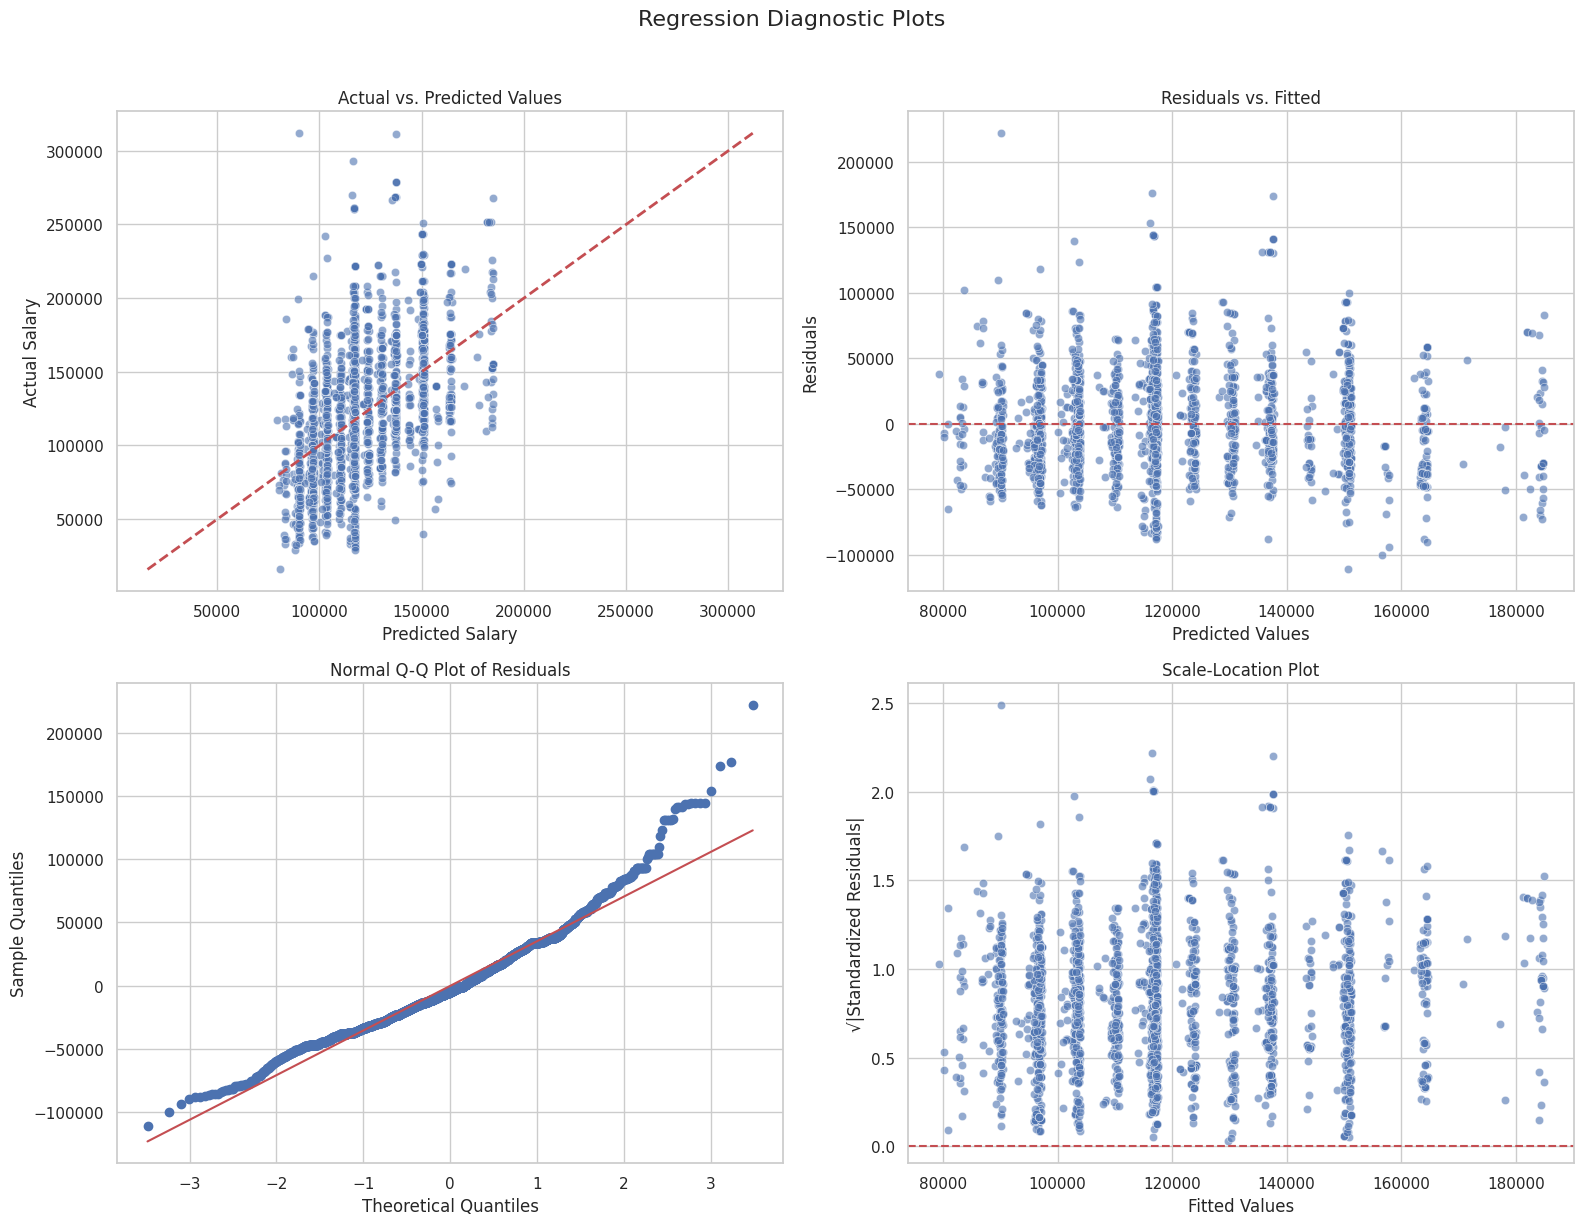

In [58]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Assuming predictions DataFrame contains 'SALARY' (actual) and 'prediction' columns
# If not, replace with your actual column names
df_pred = predictions.select("SALARY", "prediction").toPandas()

# Compute residuals and fitted values
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# Standardize residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

# Square root of absolute standardized residuals (for Scale-Location plot)
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Set up plot grid
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid", palette="deep")
plt.suptitle('Regression Diagnostic Plots', y=1.02, fontsize=16)

# Plot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
sns.scatterplot(x='fitted', y='SALARY', data=df_pred, alpha=0.6)
plt.plot([df_pred['SALARY'].min(), df_pred['SALARY'].max()], 
         [df_pred['SALARY'].min(), df_pred['SALARY'].max()], 
         'r--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')

# Plot 2: Residuals vs Fitted
plt.subplot(2, 2, 2)
sns.scatterplot(x='fitted', y='residuals', data=df_pred, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot 3: Q-Q Plot
plt.subplot(2, 2, 3)
stats.probplot(df_pred['residuals'], dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Plot 4: Scale-Location Plot
plt.subplot(2, 2, 4)
sns.scatterplot(x='fitted', y='sqrt_std_resid', data=df_pred, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Scale-Location Plot')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')

plt.tight_layout()
plt.savefig("_output/glr_diagnostic_plots.png", bbox_inches='tight', dpi=300)
plt.show()

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [59]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg, count
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
pred_glr = lr_model.transform(test_data)

# Initialize evaluators
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

# Standard metrics
r2 = evaluator_r2.evaluate(pred_glr)
rmse = evaluator_rmse.evaluate(pred_glr)
mae = evaluator_mae.evaluate(pred_glr)

# Information Criteria (AIC/BIC)
n = pred_glr.count()  # Number of observations
k = len(lr_model.coefficients) + 1  # Number of parameters (features + intercept)

# Calculate Residual Sum of Squares
residuals_df = pred_glr.withColumn("residual_squared", pow(col("SALARY") - col("prediction"), 2))
rss = residuals_df.select(avg("residual_squared")).collect()[0][0] * n

# Calculate AIC/BIC
aic = n * np.log(rss/n) + 2 * k
bic = n * np.log(rss/n) + k * np.log(n)

# Create metrics table
metrics = pd.DataFrame({
    "Metric": ["R-squared", "RMSE", "MAE", "AIC", "BIC"],
    "Value": [r2, rmse, mae, aic, bic],
    "Interpretation": [
        "Proportion of variance explained (higher better)",
        "Average prediction error in $ (lower better)",
        "Mean absolute error in $ (lower better)",
        "Model fit with parameter penalty (lower better)",
        "Stronger penalty for complex models (lower better)"
    ]
})

# Print metrics
print(tabulate(metrics, headers="keys", tablefmt="github", showindex=False))

| Metric    |        Value | Interpretation                                     |
|-----------|--------------|----------------------------------------------------|
| R-squared |     0.281465 | Proportion of variance explained (higher better)   |
| RMSE      | 35894.9      | Average prediction error in $ (lower better)       |
| MAE       | 27776.9      | Mean absolute error in $ (lower better)            |
| AIC       | 58996.5      | Model fit with parameter penalty (lower better)    |
| BIC       | 59026.2      | Stronger penalty for complex models (lower better) |


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

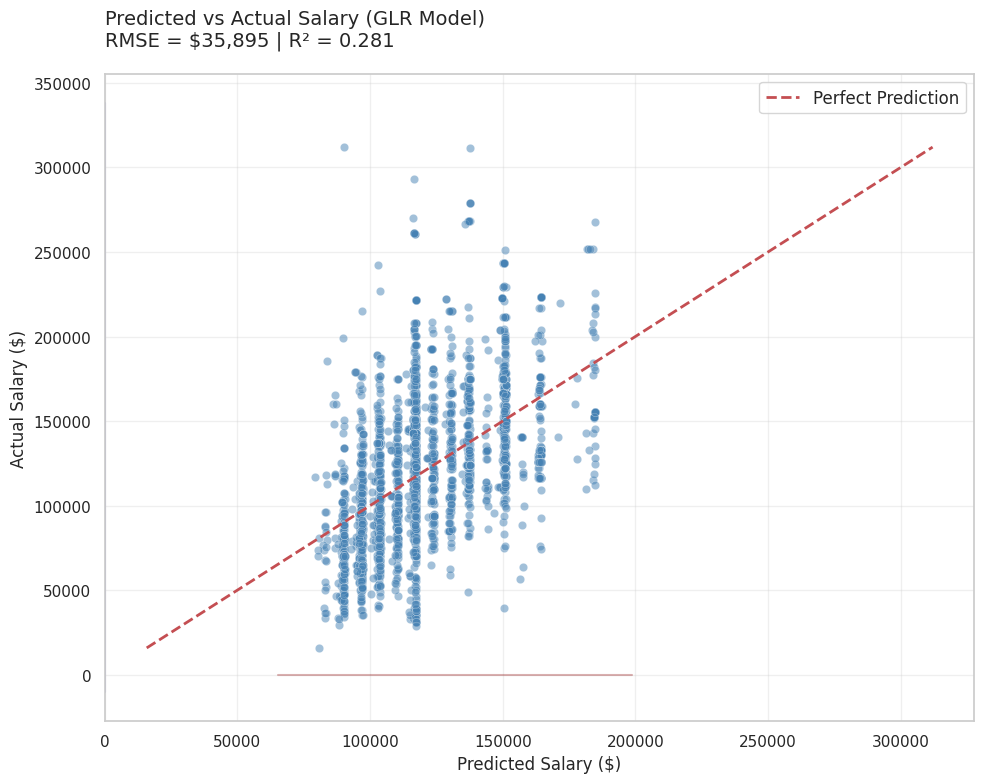

In [61]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to pandas (with sampling if large dataset)
pandas_df = pred_glr.sample(False, 0.1).toPandas() if pred_glr.count() > 5000 else pred_glr.toPandas()

# Create plot
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    x="prediction", 
    y="SALARY", 
    data=pandas_df,
    alpha=0.5,
    color='steelblue',
    edgecolor='w',
    linewidth=0.3
)

# Add perfect prediction line
max_val = max(pandas_df["SALARY"].max(), pandas_df["prediction"].max())
min_val = min(pandas_df["SALARY"].min(), pandas_df["prediction"].min())
plt.plot([min_val, max_val], [min_val, max_val], 
         'r--', lw=2, label='Perfect Prediction')

# Add annotations and styling
plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = ${rmse:,.0f} | R² = {r2:.3f}", 
          loc="left", pad=20, fontsize=14)
plt.xlabel("Predicted Salary ($)", fontsize=12)
plt.ylabel("Actual Salary ($)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add marginal distribution
sns.kdeplot(x=pandas_df["prediction"], color='darkred', alpha=0.3, ax=ax)
sns.kdeplot(y=pandas_df["SALARY"], color='darkblue', alpha=0.3, ax=ax)

plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

## Key Observations:

### Prediction Accuracy: 
The scatter plot shows moderate clustering around the red ideal line (y=x), indicating reasonable but imperfect predictions. Points deviate more noticeably at higher salary ranges, suggesting the model struggles with high-earner estimates.

### Error Patterns:

- Underestimation: Many points lie above the line (actual > predicted), particularly for salaries >$100k, revealing a tendency to under-predict high salaries.

- Overestimation: Fewer points below the line (actual < predicted) for lower salaries, but some outliers exist.

### Metric Context:
- The annotated RMSE ($36k) and R² (0.28) align with the visual spread:

- Predictions are directionally useful but lack precision (wide vertical dispersion).

- The model explains only 27.7% of variance, highlighting unaccounted factors (e.g., job title, location).

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
